In [16]:
import numpy as np
from scipy import special
from scipy import optimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm #colormap

In [2]:
%matplotlib notebook

In [3]:
#Constantes fijas
ec = 1.60217662E-19 #C
m = 9.10938356E-31 #kg
hbar = 1.054571817E-34 #J*s
c_light = 299792458 #m/s
epsilon0 = 8.8541878128E-12 #C^2/(N*m^2)
mu0 = np.pi*4E-7 #N/A^2
alpha = 1/137.035999084 #Constante de estructura fina

#Cantidades fundamentales
l_compton = hbar/(m*c_light) #m
phi_0 = 2*np.pi*hbar/ec #T/m^2
Quantum_R = phi_0/ec #Ohm

#Densidad electrónica superficial (Viene del Tong, pero es medio arbitrario tomarsela)
n_e = 5E15 #m^(-2)
#n_e = 5E20 #intento de aumentar el llenado

n_c = (3**(2/3)-1)**3*9*alpha**2*np.pi/(4**3*l_compton**2) #m^(-2) Densidad compton

ctes = [ec,m,hbar,c_light,epsilon0,mu0,alpha,l_compton,phi_0,Quantum_R]

#Funcion que calcula todos los parámetros importantes:
def Parámetros_Sistema(E, B, L, ctes):
    '''
    Funcion que calcula todos los parámetros importantes para un sistema (Campo magnético, eléctrico, L).
    Los que dependen del estado se calculan aparte, para no llamar a esta función varias veces
    '''
    ec, m, hbar, c_light, epsilon0, mu0, alpha, l_compton, phi_0, Quantum_R = ctes
    
    B_tilde = alpha*E/c_light
    E_tilde = -alpha*c_light*B
    
    w_B = ec*B/m
    
    l_B = np.sqrt(hbar/(ec*B))
    l_Btilde = np.sqrt(hbar/(ec*B_tilde))
    l_E = (hbar**2/(2*m*ec*E))**(1/3)
    #if E_tilde >= 0:
    #    l_Etilde = (hbar**2/(2*m*ec*E_tilde))**(1/3)
    #else:
    #    l_Etilde = -(-hbar**2/(2*m*ec*E_tilde))**(1/3) #A python no parece gustarle raíces cúbicas negativas
    l_Etilde = -(-hbar**2/(2*m*ec*E_tilde))**(1/3) #Asumimos E_tilde negativa por ahora, para poder usar arrays
    
    Gamma = L/l_Etilde
    epsilon = -alpha*l_Etilde/l_compton
    
    return [E, B, L, B_tilde, E_tilde, l_B, l_E, l_Btilde, l_Etilde, Gamma, epsilon]

In [4]:
def sigma_wkb(Gamma,N):
    #Supongemos Gamma negativa
    a_N = -(3*np.pi/2)**(2/3)*(N+0.5)**(2/3)
    return -np.sqrt(np.abs(Gamma-a_N))
    #return -np.abs(Gamma-a_N)

#Se debe tener N<(2/(3*np.pi))*Gamma**(3/2)-1/2
def N_Posibles(Gamma):
    '''
    Calcula las N posibles para una Gamma
    '''
    #Ni = np.int64(np.floor((2/(3*np.pi))*(Gamma)**(3/2)-1/2))+1
    Ni = np.int64(np.floor((2/(3*np.pi))*(-Gamma)**(3/2)-1/2))+1 #suponemos Gamma negativa
    #return np.arange(0,Ni,1.0)
    return Ni

In [5]:
def F(s,z): #ESTA DIFIERE CON EL SISTEMA 2, AQUI YA HACEMOS EL CAMBIO DE SIGNO EN SIGMA Y GAMMA
    ais, aips, bis, bips = special.airy(s**2)
    ait, aipt, bit, bipt = special.airy(s**2+z)
    return ((s*ais-aips)*(s*bit+bipt)-(s*bis-bips)*(s*ait+aipt))
    #return ((s*ais+aips)*(s*bit-bipt)-(s*bis+bips)*(s*ait-aipt))*10E-50 #Le bajamos de magntidud para que no se salga del rango de numpy tan rápido, no afecta los ceros

<IPython.core.display.Javascript object>


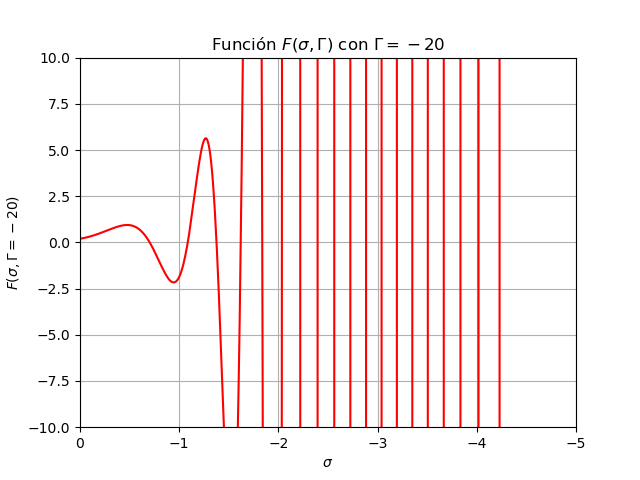

In [10]:
s=np.arange(-10,10,0.01)
z = -20
plt.plot(s,F(s,z),'r')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$F(\sigma,\Gamma = -20)$')
plt.title(r'Función $F(\sigma,\Gamma)$ con $\Gamma = -20$')
plt.ylim(-10,10)
plt.xlim(0,-5)
plt.grid()
plt.show()

In [6]:
def RootF(z):
    '''
    Calcula la lista de n raíces en sigma (ordenadas de mayor a menor) para F(sigma,z)
    '''
    d=-0.1
    #d = -0.1*30/(-z)
    RootZ = []
    for s in np.arange(0,-np.sqrt(-z),d): #Para negativas
    #for s in np.arange(-0.1,8,d):
        if F(s,z)*F(s+d,z) <= 0:
            sol = optimize.root_scalar(F,args=(z),bracket=[s,s+d])
            if not np.any(np.abs(np.array(RootZ)-sol.root) < 0.0001): #and sol.root>=0:
                RootZ.append(sol.root)
    return np.flip(np.array(RootZ))
    #return np.array(RootZ)

In [7]:
def Curvas(zmin,zmax,numZ):
    '''
    Lista[n][i][j] la n-ésima curva (de mayor a menor), i=0 para su j-esima coord en z, i=1 para su j-esima coord en sigma.
    '''
    Z = np.linspace(zmin,zmax,numZ)
    Lista = [[[],[]]]
    N = 1
    for z in Z:
        RootZ = RootF(z)
        while len(RootZ) > N:
        #if len(RootZ) > N:
            #N = len(RootZ)
            N += 1
            Lista.append([[],[]])
        n = 0
        for sigma in RootZ:
            Lista[n][0].append(z)
            Lista[n][1].append(sigma)
            n+=1
    return Lista

In [47]:
Lista = Curvas(-30,0,10000) #10000

<IPython.core.display.Javascript object>


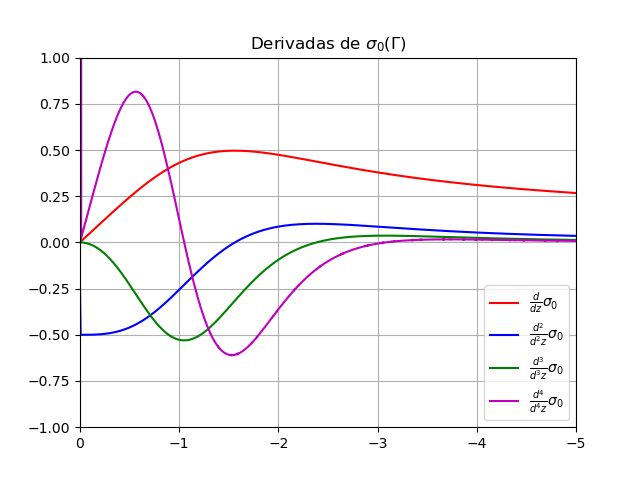

In [19]:
zo = Lista[0][0]
so = Lista[0][1]
sop = np.gradient(so,zo)
plt.plot(zo,sop,'r',label = r'$\frac{d}{dz}\sigma_{0}$')
sopp = np.gradient(sop,zo)
plt.plot(zo,sopp,'b',label = r'$\frac{d^2}{d^2z}\sigma_{0}$')
soppp = np.gradient(sopp,zo)
plt.plot(zo,soppp,'g',label = r'$\frac{d^3}{d^3z}\sigma_{0}$')
sopppp = np.gradient(soppp,zo)
plt.plot(zo,sopppp,'m',label = r'$\frac{d^4}{d^4z}\sigma_{0}$')
plt.grid()
plt.legend()
plt.xlim(0,-5)
plt.ylim(-1,1)
plt.title(r'Derivadas de $\sigma_{0}(\Gamma)$')
plt.show()

<IPython.core.display.Javascript object>


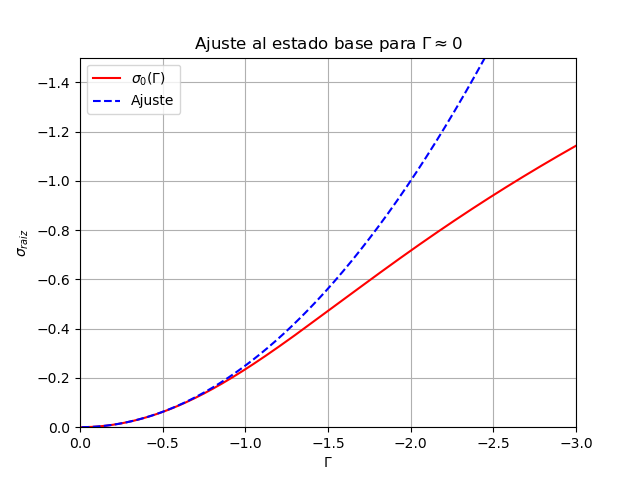

In [25]:
#Graficando la aproximacion a z pequeños
z = np.array(Lista[0][0])
plt.plot(z,np.array(Lista[0][1]),'r',label=r'$\sigma_0(\Gamma)$')
plt.plot(z,-0.25*z**2,'b--',label='Ajuste')
plt.title(r'Ajuste al estado base para $\Gamma \approx 0$')
plt.xlabel(r'$\Gamma$')
plt.ylabel(r'$\sigma_{raiz}$')
plt.legend()
plt.xlim(0,-3)
plt.ylim(0,-1.5)
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


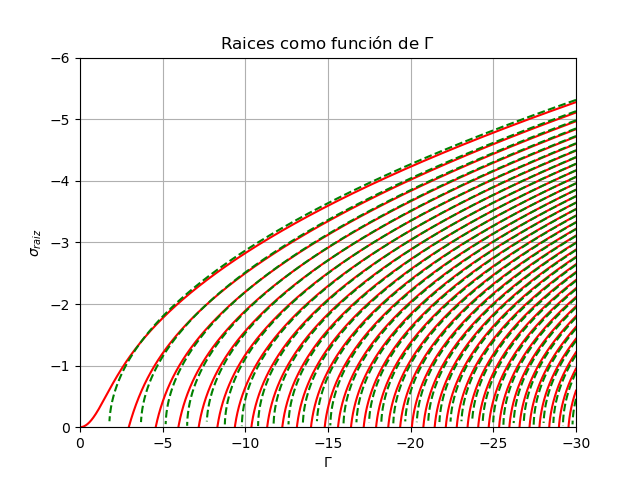

In [48]:
for n in range(0,len(Lista)):
    plt.plot(np.array(Lista[n][0]),np.array(Lista[n][1]),'r')
for N in range(0,50): #Ajuste WkB
    a = -(3*np.pi/2)**(2/3)*(N+1/2)**(2/3) #para negativas
    zi = np.arange(-300,a,0.01)
    si = sigma_wkb(zi,N)
    plt.plot(zi,si,'g--')
plt.title(r'Raices como función de $\Gamma$')
plt.xlabel(r'$\Gamma$')
plt.ylabel(r'$\sigma_{raiz}$')
plt.xlim(0,-30)
plt.ylim(0,-6)
plt.grid()
plt.show()

In [8]:
def G(s,z):
    ais, aips, bis, bips = special.airy(s**2)
    ait, aipt, bit, bipt = special.airy(s**2+z)
    return bit*(aips-s*ais)+ait*(s*bis-bips)

<IPython.core.display.Javascript object>


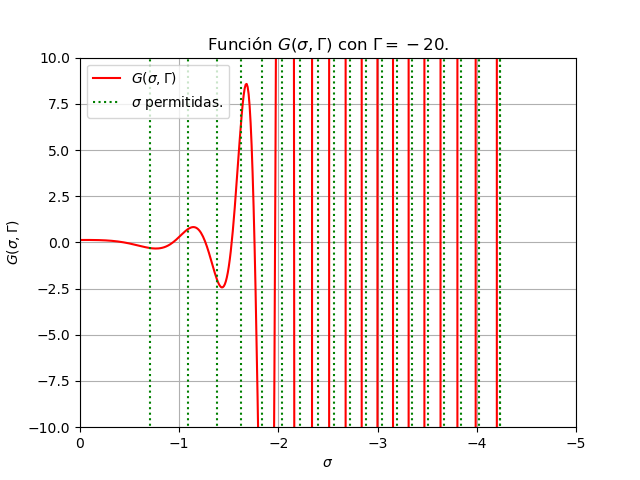

In [188]:
s=np.arange(-10,10,0.01)
z = -20
plt.plot(s,G(s,z),'r',label=r'$G(\sigma,\Gamma)$')

S = RootF(z)
Y = np.arange(-100,100,1)
plt.plot([S[0]]*len(Y),Y,'g:',label=r'$\sigma$ permitidas.')
for s in S:
    plt.plot([s]*len(Y),Y,'g:')

plt.xlabel(r'$\sigma$')
plt.ylabel(r'$G(\sigma,\Gamma)$')
plt.title(r'Función $G(\sigma,\Gamma)$ con $\Gamma = -20$.')
plt.ylim(-10,10)
plt.xlim(0,-5)
plt.grid()
plt.legend()
plt.show()

In [9]:
def I_kk(s,z):
    Gs = np.pi*G(s,z)
    return -((z*(2*s**2-z)/3+s/3)*Gs**2+s/3)*2*s/(1+(1+2*s*z)*Gs**2)

def I_kkp(s,sp,z):
    Gs = np.pi*G(s,z)
    Gsp = np.pi*G(sp,z)
    Delta = sp**2-s**2
    A = 2*np.sqrt(sp*s/((1+(1+2*sp*z)*Gsp**2)*(1+(1+2*s*z)*Gs**2)))
    return -((2/((s-sp)**2*(s+sp)**3)+1/(s+sp)**2+z*(1/(s+sp)+2/(sp**2-s**2)**2))*Gsp*Gs+2/((s-sp)**2*(s+sp)**3)-1/(s+sp)**2)*A

<IPython.core.display.Javascript object>


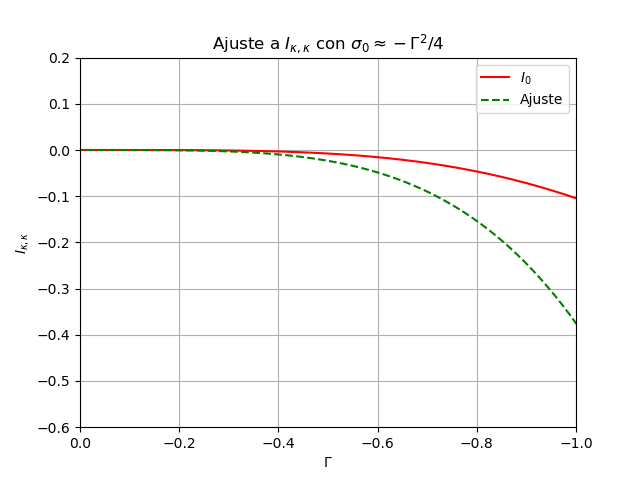

In [91]:
zo = np.array(Lista[0][0])
so = np.array(Lista[0][1])
I_kko = I_kk(so,zo)
plt.plot(zo,I_kko,'r',label = r'$I_{0}$')
plt.plot(zo,-3*zo**4/8,'g--',label = 'Ajuste')

#I_kkop = np.gradient(I_kko,zo)
#plt.plot(zo,I_kkop,'r',label = r'$\frac{d}{dz}\I_{\kappa,\kappa}$')
#I_kkopp = np.gradient(I_kkop,zo)
#plt.plot(zo,I_kkopp,'b',label = r'$\frac{d^2}{d^2z}\I_{\kappa,\kappa}$')
#I_kkoppp = np.gradient(I_kkopp,zo)
#plt.plot(zo,I_kkoppp,'g',label = r'$\frac{d^3}{d^3z}\I_{\kappa,\kappa}$')
#I_kkopppp = np.gradient(I_kkoppp,zo)
#plt.plot(zo,I_kkopppp,'m',label = r'$\frac{d^4}{d^4z}\I_{\kappa,\kappa}$')

plt.xlabel(r'$\Gamma$')
plt.ylabel(r'$I_{\kappa,\kappa}$')
plt.title(r'Ajuste a $I_{\kappa,\kappa}$ con $\sigma_0 \approx -\Gamma^2/4$')
plt.ylim(-0.6,0.2)
plt.xlim(0,-1)
plt.legend()
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


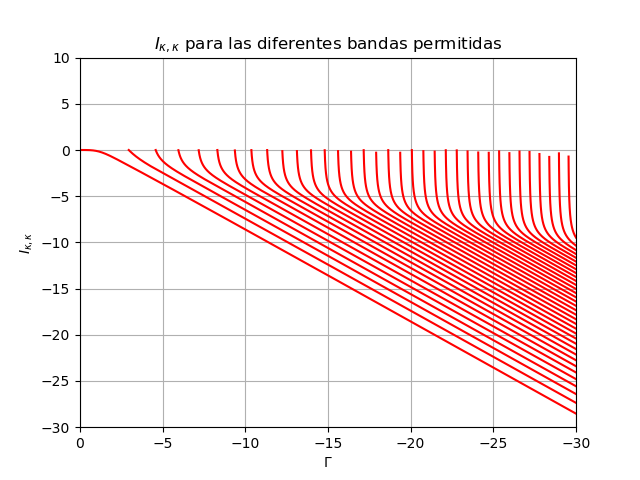

In [115]:
for n in range(0,len(Lista)):
    zi = np.array(Lista[n][0])
    si = np.array(Lista[n][1])
    I_kki = I_kk(si,zi)
    plt.plot(zi,I_kki,'r')

plt.xlabel(r'$\Gamma$')
plt.ylabel(r'$I_{\kappa,\kappa}$')
plt.title(r'$I_{\kappa,\kappa}$ para las diferentes bandas permitidas')
plt.ylim(-30,10)
plt.xlim(0,-30)
plt.grid()
plt.show()

In [10]:
def Ajuste1_Ikk(s,z):
    return -(z*(2*s**2-z)/3+s/3)*2*s/(1+2*s*z)

<IPython.core.display.Javascript object>


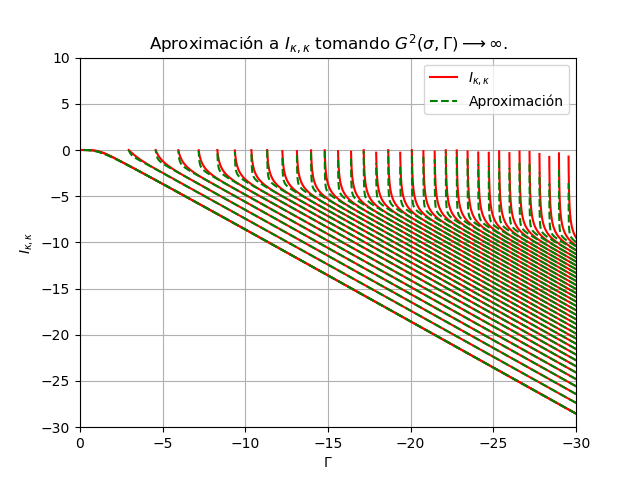

In [71]:
zi = np.array(Lista[0][0])
si = np.array(Lista[0][1])
I_kki = I_kk(si,zi)
plt.plot(zi,I_kki,'r', label=r'$I_{\kappa,\kappa}$')
AjusteI_kki = Ajuste1_Ikk(si,zi)
plt.plot(zi,AjusteI_kki,'g--', label='Aproximación' )

for n in range(0,len(Lista)):
    zi = np.array(Lista[n][0])
    si = np.array(Lista[n][1])
    I_kki = I_kk(si,zi)
    plt.plot(zi,I_kki,'r')
    AjusteI_kki = Ajuste1_Ikk(si,zi)
    plt.plot(zi,AjusteI_kki,'g--')

plt.xlabel(r'$\Gamma$')
plt.ylabel(r'$I_{\kappa,\kappa}$')
plt.title(r'Aproximación a $I_{\kappa,\kappa}$ tomando $G^2(\sigma,\Gamma)\longrightarrow \infty$.')
plt.ylim(-30,10)
plt.xlim(0,-30)
plt.grid()
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


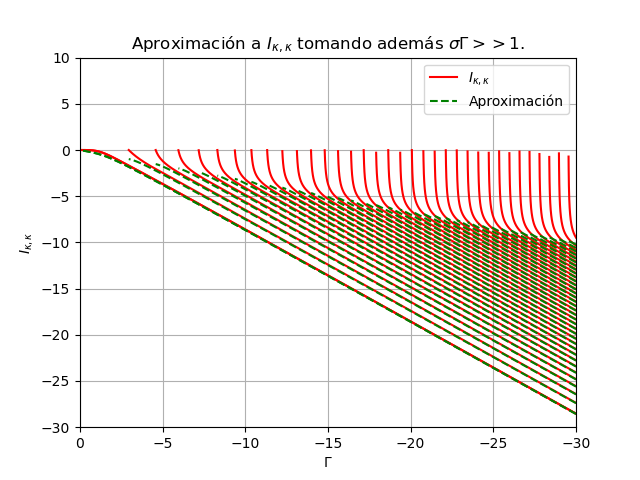

In [21]:
zi = np.array(Lista[0][0])
si = np.array(Lista[0][1])
I_kki = I_kk(si,zi)
plt.plot(zi,I_kki,'r', label=r'$I_{\kappa,\kappa}$')
AjusteI_kki = (zi-2*si**2)/3
plt.plot(zi,AjusteI_kki,'g--', label='Aproximación' )

for n in range(0,len(Lista)):
    zi = np.array(Lista[n][0])
    si = np.array(Lista[n][1])
    I_kki = I_kk(si,zi)
    plt.plot(zi,I_kki,'r')
    AjusteI_kki = (zi-2*si**2)/3
    plt.plot(zi,AjusteI_kki,'g--')

plt.xlabel(r'$\Gamma$')
plt.ylabel(r'$I_{\kappa,\kappa}$')
plt.title(r'Aproximación a $I_{\kappa,\kappa}$ tomando además $\sigma\Gamma >> 1$.')
plt.ylim(-30,10)
plt.xlim(0,-30)
plt.grid()
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


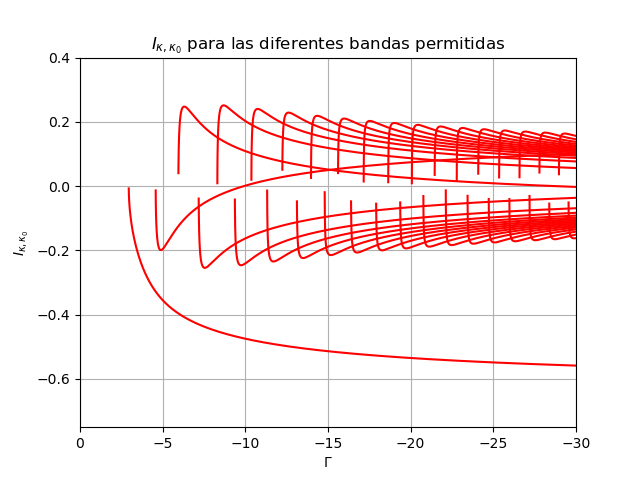

In [33]:
s0 = np.array(Lista[0][1])
for n in range(1,len(Lista)):
    zi = np.array(Lista[n][0])
    si = np.array(Lista[n][1])
    s0i = s0[:len(si)] #Las recorto para que tengan la misma longitud (y creo que misma posición)
    I_kkpi = I_kkp(si,s0i,zi)
    plt.plot(zi,I_kkpi,'r')

plt.xlabel(r'$\Gamma$')
plt.ylabel(r'$I_{\kappa,\kappa_0}$')
plt.title(r'$I_{\kappa,\kappa_0}$ para las diferentes bandas permitidas')
plt.ylim(-0.75,0.4)
plt.xlim(0,-30)
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


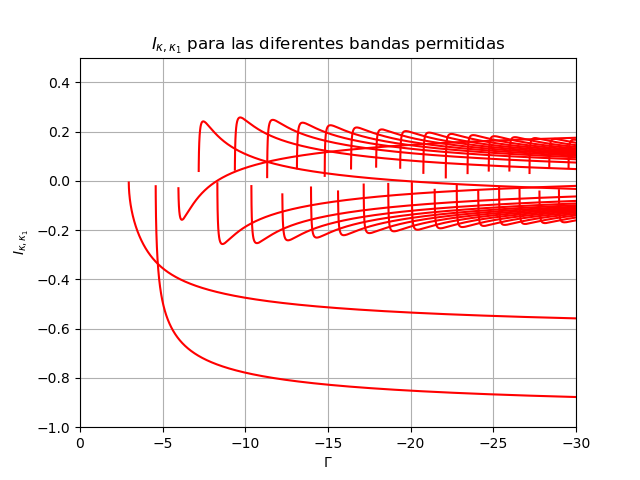

In [32]:
s1 = np.array(Lista[1][1])

zi = np.array(Lista[0][0])
si = np.array(Lista[0][1])
si1 = si[:len(s1)] #Las recorto para que tengan la misma longitud (y creo que misma posición)
zi1 = zi[:len(s1)] #Las recorto para que tengan la misma longitud (y creo que misma posición)
I_kkpi = I_kkp(si1,s1,zi1)
plt.plot(zi1,I_kkpi,'r')
for n in range(2,len(Lista)):
    zi = np.array(Lista[n][0])
    si = np.array(Lista[n][1])
    s1i = s1[:len(si)] #Las recorto para que tengan la misma longitud (y creo que misma posición)
    I_kkpi = I_kkp(si,s1i,zi)
    plt.plot(zi,I_kkpi,'r')

plt.xlabel(r'$\Gamma$')
plt.ylabel(r'$I_{\kappa,\kappa_1}$')
plt.title(r'$I_{\kappa,\kappa_1}$ para las diferentes bandas permitidas')
plt.ylim(-1,0.5)
plt.xlim(0,-30)
plt.grid()
plt.show()

In [11]:
def Ajuste1_Ikkp(s,sp,z):
    return -(z+1/(s+sp))*(1/(s+sp)+2/(sp**2-s**2)**2)*2*np.sqrt(s*sp)/(np.sqrt(1+2*s*z)*np.sqrt(1+2*sp*z))

<IPython.core.display.Javascript object>


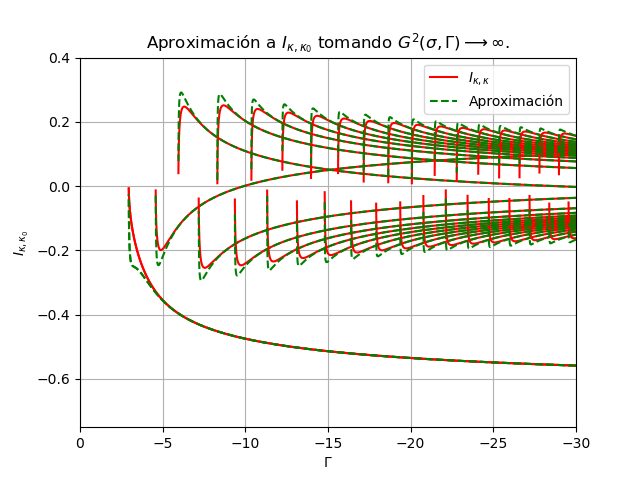

In [25]:
s0 = np.array(Lista[0][1])

zi = np.array(Lista[1][0])
si = np.array(Lista[1][1])
s0i = s0[:len(si)] #Las recorto para que tengan la misma longitud (y creo que misma posición)
I_kkpi = I_kkp(si,s0i,zi)
plt.plot(zi,I_kkpi,'r',label=r'$I_{\kappa,\kappa}$')
AjusteI_kkpi = -Ajuste1_Ikkp(si,s0i,zi)
plt.plot(zi,AjusteI_kkpi,'g--',label='Aproximación')
for n in range(1,len(Lista)):
    zi = np.array(Lista[n][0])
    si = np.array(Lista[n][1])
    s0i = s0[:len(si)] #Las recorto para que tengan la misma longitud (y creo que misma posición)
    I_kkpi = I_kkp(si,s0i,zi)
    plt.plot(zi,I_kkpi,'r')
    AjusteI_kkpi = (-1)**n*Ajuste1_Ikkp(si,s0i,zi)
    plt.plot(zi,AjusteI_kkpi,'g--')
    
plt.xlabel(r'$\Gamma$')
plt.ylabel(r'$I_{\kappa,\kappa_0}$')
plt.title(r'Aproximación a $I_{\kappa,\kappa_0}$ tomando $G^2(\sigma,\Gamma)\longrightarrow \infty$.')
plt.ylim(-0.75,0.4)
plt.xlim(0,-30)
plt.legend()
plt.grid()
plt.show()

In [12]:
def Ajuste2_Ikkp(s,sp,z):
    return -(1/(s+sp)+2/(sp**2-s**2)**2)

<IPython.core.display.Javascript object>


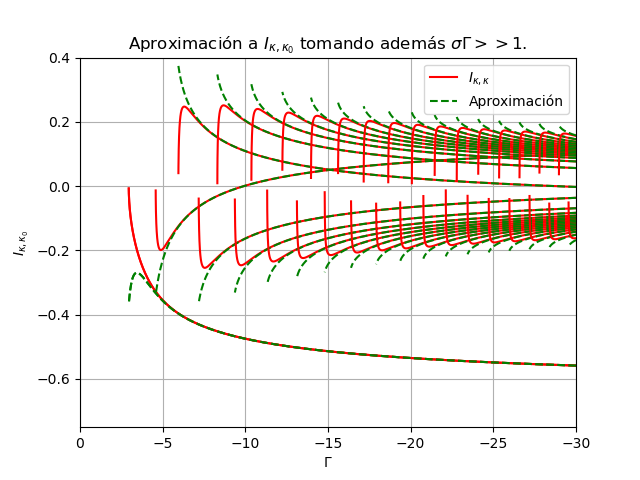

In [20]:
s0 = np.array(Lista[0][1])

zi = np.array(Lista[1][0])
si = np.array(Lista[1][1])
s0i = s0[:len(si)] #Las recorto para que tengan la misma longitud (y creo que misma posición)
I_kkpi = I_kkp(si,s0i,zi)
plt.plot(zi,I_kkpi,'r',label=r'$I_{\kappa,\kappa}$')
AjusteI_kkpi = Ajuste2_Ikkp(si,s0i,zi)
plt.plot(zi,AjusteI_kkpi,'g--',label='Aproximación')
for n in range(1,len(Lista)):
    zi = np.array(Lista[n][0])
    si = np.array(Lista[n][1])
    s0i = s0[:len(si)] #Las recorto para que tengan la misma longitud (y creo que misma posición)
    I_kkpi = I_kkp(si,s0i,zi)
    plt.plot(zi,I_kkpi,'r')
    AjusteI_kkpi = (-1)**(n+1)*Ajuste2_Ikkp(si,s0i,zi)
    plt.plot(zi,AjusteI_kkpi,'g--')
    
plt.xlabel(r'$\Gamma$')
plt.ylabel(r'$I_{\kappa,\kappa_0}$')
plt.title(r'Aproximación a $I_{\kappa,\kappa_0}$ tomando además $\sigma\Gamma >> 1$.')
plt.ylim(-0.75,0.4)
plt.xlim(0,-30)
plt.legend()
plt.grid()
plt.show()

In [13]:
def rho_0(nu,mu):
    return Quantum_R/(nu*mu)

<IPython.core.display.Javascript object>


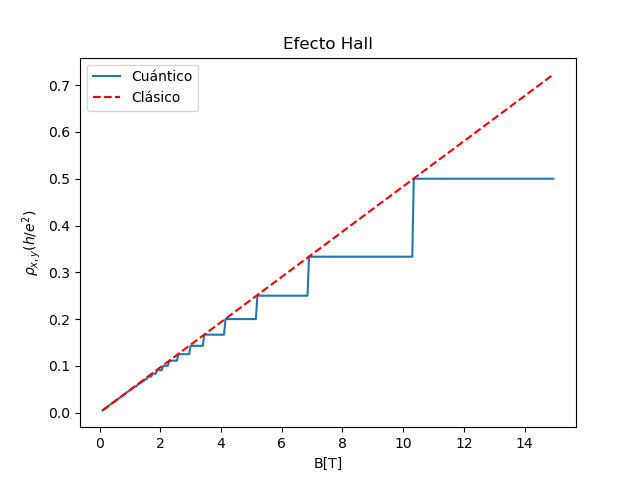

In [33]:
B = np.arange(0.1,15,0.05)
n_e = 5E15 #m^(-2)
mu = 1 #Suponemos sólo un nivel en kappa
nu = np.ceil(n_e/(B/phi_0)) #Numero de niveles de Landau con ocupación
#nu = np.rint(n_e/(B/phi_0))
plt.plot(B,rho_0(nu,mu)/Quantum_R,label='Cuántico')
plt.plot(B,B/(n_e*ec)/Quantum_R,'r--',label='Clásico')
plt.title('Efecto Hall')
plt.xlabel('B[T]')
plt.ylabel(r'$\rho_{x,y}(h/e^2)$')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


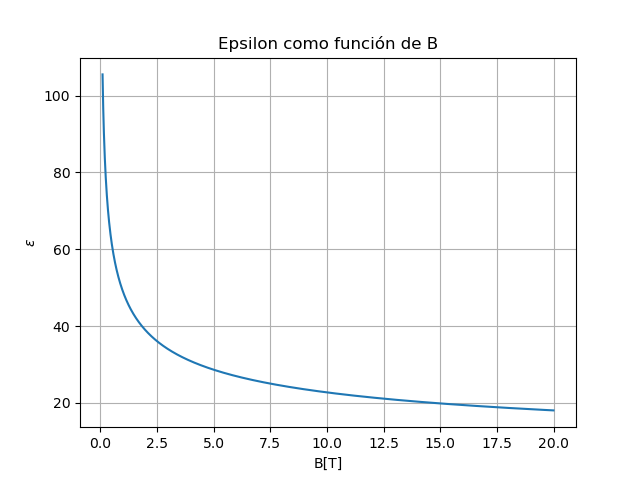

In [62]:
#Gráfica de epsilon
B = np.arange(0.1,20,0.01)
E_tilde = -alpha*c_light*B
l_Etilde = -(-hbar**2/(2*m*ec*E_tilde))**(1/3)
epsilon = -alpha*l_Etilde/l_compton
plt.plot(B,epsilon)
plt.title('Epsilon como función de B')
plt.xlabel('B[T]')
plt.ylabel(r'$\epsilon$')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


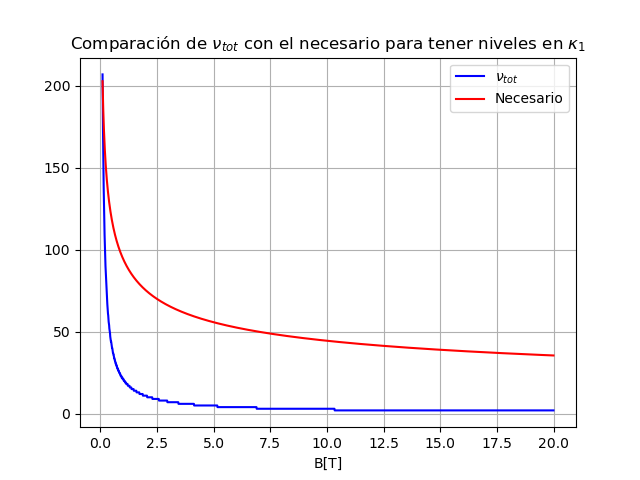

In [34]:
#Gráfica del llenado
n_e = 5E15 #m^(-2) Tong
#n_e = 5E16 #intento de aumentar el llenado

B = np.arange(0.1,20,0.01)
total = np.ceil(n_e*phi_0/B)
Necesario = 1+(n_c*phi_0/B)**(1/3)

plt.plot(B,total,'b',label=r'$\nu_{tot}$')
plt.plot(B,Necesario,'r',label='Necesario')
plt.title(r'Comparación de $\nu_{tot}$ con el necesario para tener niveles en $\kappa_1$')
plt.xlabel('B[T]')
#plt.ylim(0,100)
plt.legend()
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


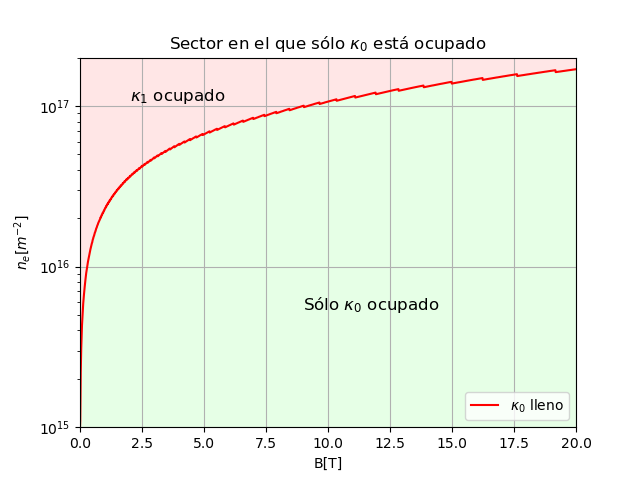

In [36]:
#Gráfica del sector con estado base
dn_e = 1E14
nmin = 1E15
nmax = 2E17
n_e = np.arange(nmin,nmax,dn_e) #m^(-2)
b = np.arange(0.00001,20,0.01)

B, N_e = np.meshgrid(b, n_e)

total = np.ceil(N_e*phi_0/B)
Necesario = 1+(n_c*phi_0/B)**(1/3)

Estado_Base = Necesario > total
N_e_critico = np.sum(Estado_Base,axis=0)*dn_e+nmin

plt.plot(b,N_e_critico,'r',label = r'$\kappa_0$ lleno')
plt.fill_between(b,N_e_critico,nmax,color=(1,0.9,0.9))
plt.fill_between(b,N_e_critico,0,color=(0.9,1,0.9))
plt.yscale('log')
plt.xlim(0,20)
plt.ylim(nmin,2E17)
plt.xlabel('B[T]')
plt.ylabel(r'$n_e[m^{-2}]$')
plt.title(r'Sector en el que sólo $\kappa_0$ está ocupado')
plt.legend(loc='lower right')
plt.grid()

ax = plt.gca()
ax.text(9, 5E15, r'Sólo $\kappa_0$ ocupado', fontsize=12, va='bottom')
ax.text(2, 1E17, r'$\kappa_1$ ocupado', fontsize=12, va='bottom')

plt.show()

<IPython.core.display.Javascript object>


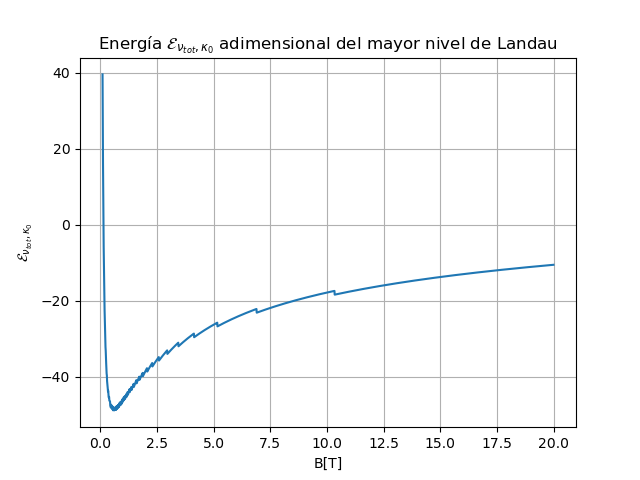

In [37]:
#Gráfica de la energía del mayor nivel de Landau base
n_e = 5E15 #m^(-2) Tong
#n_e = 5E16 #intento de aumentar el llenado
L = 1E-9 #Suponemos nanómetros

B = np.arange(0.1,20,0.01)
total = np.ceil(n_e*phi_0/B)
E_tilde = -alpha*c_light*B
l_Etilde = -(-hbar**2/(2*m*ec*E_tilde))**(1/3) #Asumimos E_tilde negativa por ahora, para poder usar arrays
Gamma = L/l_Etilde
epsilon = -alpha*l_Etilde/l_compton
sigma = sigma_wkb(Gamma,0) #Estado base en kappa

Energía = total+0.5-epsilon*sigma**2

plt.plot(B,Energía)
plt.title(r'Energía $\mathcal{E}_{\nu_{tot},\kappa_0}$ adimensional del mayor nivel de Landau')
#plt.ylim(-30,10)
plt.xlabel('B[T]')
plt.ylabel(r'$\mathcal{E}_{\nu_{tot},\kappa_0}$')
plt.grid()
plt.show()


<IPython.core.display.Javascript object>


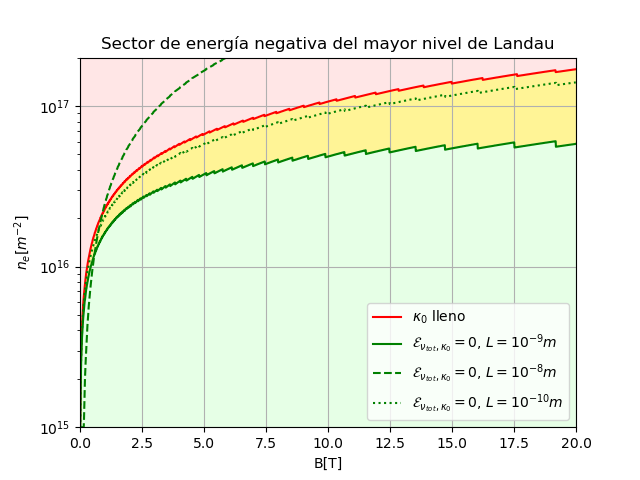

In [45]:
#Gráfica del sector con estado base
L = 1E-9 #Nanómetros parece ser el peor de los casos

dn_e = 1E14
nmin = 1E15
nmax = 2E17
n_e = np.arange(nmin,nmax,dn_e) #m^(-2)
b = np.arange(0.00001,20,0.01)

B, N_e = np.meshgrid(b, n_e)

total = np.ceil(N_e*phi_0/B)
Necesario = 1+(n_c*phi_0/B)**(1/3)

Estado_Base = Necesario > total #Sector en el que sólo kappa_0 está lleno
N_e_critico = np.sum(Estado_Base,axis=0)*dn_e+nmin

E_tilde = -alpha*c_light*B
l_Etilde = -(-hbar**2/(2*m*ec*E_tilde))**(1/3) #Asumimos E_tilde negativa por ahora, para poder usar arrays
Gamma = L/l_Etilde
epsilon = -alpha*l_Etilde/l_compton
sigma = sigma_wkb(Gamma,0) #Estado base en kappa

Energía = total+0.5-epsilon*sigma**2
E_negativa = Energía < 0 #Sector en el que el mayor nivel de Landau aún es negativo
N_e_critico2 = np.sum(E_negativa,axis=0)*dn_e+nmin

#total_hall = total < 1 #Sector en el que hay meseta n=1
#N_e_critico3 = np.sum(total_hall,axis=0)*dn_e+nmin

plt.plot(b,N_e_critico,'r',label = r'$\kappa_0$ lleno')
plt.fill_between(b,N_e_critico,nmax,color=(1,0.9,0.9)) #rojo

plt.plot(b,N_e_critico2,'g',label = r'$\mathcal{E}_{\nu_{tot},\kappa_0} = 0$, $L = 10^{-9}m$')
plt.fill_between(b,N_e_critico2,N_e_critico,color=(255/255,244/255,150/255)) #amarillo
plt.fill_between(b,N_e_critico2,0,color=(0.9,1,0.9)) #verde

L = 1E-8
Gamma = L/l_Etilde
sigma = sigma_wkb(Gamma,0) #Estado base en kappa
Energía = total+0.5-epsilon*sigma**2
E_negativa = Energía < 0 #Sector en el que el mayor nivel de Landau aún es negativo
N_e_critico2 = np.sum(E_negativa,axis=0)*dn_e+nmin
plt.plot(b,N_e_critico2,'g--',label = r'$\mathcal{E}_{\nu_{tot},\kappa_0} = 0$, $L = 10^{-8}m$')

L = 1E-10
Gamma = L/l_Etilde
sigma = sigma_wkb(Gamma,0) #Estado base en kappa
Energía = total+0.5-epsilon*sigma**2
E_negativa = Energía < 0 #Sector en el que el mayor nivel de Landau aún es negativo
N_e_critico2 = np.sum(E_negativa,axis=0)*dn_e+nmin
plt.plot(b,N_e_critico2,'g:',label = r'$\mathcal{E}_{\nu_{tot},\kappa_0} = 0$, $L = 10^{-10}m$')

#plt.plot(b,N_e_critico3,'b')
plt.yscale('log')
plt.xlim(0,20)
plt.ylim(nmin,2E17)
plt.xlabel('B[T]')
plt.ylabel(r'$n_e[m^{-2}]$')
plt.title(r'Sector de energía negativa del mayor nivel de Landau')
plt.grid()
plt.legend(loc='lower right')

#ax = plt.gca()
#ax.text(9, 5E15, r'Sólo $\kappa_0$ ocupado y $\mathcal{E}_{\nu_{tot},\kappa_0} < 0$', fontsize=12, va='bottom')
#ax.text(8, 6.5E16, r'Sólo $\kappa_0$ ocupado, pero $\mathcal{E}_{\nu_{tot},\kappa_0} > 0$', fontsize=12, va='bottom')
#ax.text(2, 1E17, r'$\kappa_1$ ocupado', fontsize=12, va='bottom')

plt.show()

In [14]:
#Lista de sumas en n precalculada
Nmax = 10000
N = np.arange(0,Nmax)
suma = np.zeros(Nmax)
for i in range(Nmax):
    n = np.arange(1,i+1)
    suma[i] = np.sum((n+1)*np.sqrt((n+2)/2)+n*np.sqrt((n-1)/2))+1 #el +1 es el caso n=0, que se cumple con total minimo 1

def f(E, B, L, n_e):
    '''
    Corrección Theta a 1 de la corriente (segundo término de la ecuación 131)
    Por simplicidad computacional usamos WkB y la primera aproximacion de I_kk
    Suponemos que estamos en el sector verde, donde sólo kappa_0 esta ocupado y sólo hay estados ligados.
    '''
    total = np.int64(np.ceil(n_e*phi_0/B))
    E, B, L, B_tilde, E_tilde, l_B, l_E, l_Btilde, l_Etilde, Gamma, epsilon = Parámetros_Sistema(E, B, L, ctes)
    sigma = sigma_wkb(Gamma,0) #Estado base en kappa
    Ikk = Ajuste1_Ikk(sigma,Gamma)
    return -l_E**3*l_Etilde**2/(l_B*l_Btilde**4)*(Ikk)**2*suma[total-1]/total

def g(E, B, L, n_e):
    '''
    Corrección Theta a 1 de la corriente (segundo término de la ecuación 131)
    '''
    total = np.int64(np.ceil(n_e*phi_0/B))
    E, B, L, B_tilde, E_tilde, l_B, l_E, l_Btilde, l_Etilde, Gamma, epsilon = Parámetros_Sistema(E, B, L, ctes)
    sigma = sigma_wkb(Gamma,0) #Estado base en kappa
    #N = N_Posibles(Gamma)
    N = np.arange(0,100,1.0) #por simplicidad aproximamos a sólo los primeros N (pueden ser demasiados en el exacto)
    sigmap = sigma_wkb(Gamma,N[1:]) #todos los kappa primas excepto el estado base
    Delta = sigmap**2-sigma**2
    Ikkp = Ajuste1_Ikkp(sigma,sigmap,Gamma) #Array de todos los kappa primas sobre los cuales se suma
    sumap = np.sum((Ikkp)**2/(epsilon*Delta)*(0.5*(total-1)/(epsilon*Delta+1)+0.5*(total+1)/(epsilon*Delta-1)+2)) #Le factorizamos el total, por el cual luego se dividía
    return -l_B**2*l_Etilde**2/(2*l_Btilde**4)*sumap

<IPython.core.display.Javascript object>


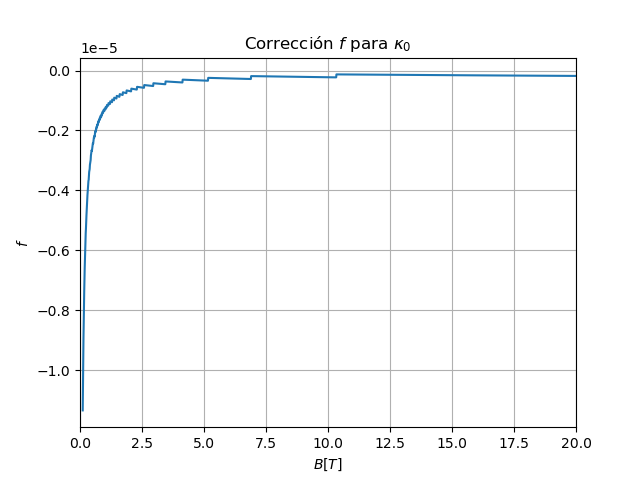

In [52]:
E = 11.54
L = 1E-3
n_e = 5E15
B = np.arange(0.11,20,0.01)
fB = f(E, B, L, n_e)
plt.plot(B,fB)

plt.xlabel(r'$B[T]$')
plt.ylabel(r'$f$')
plt.title(r'Corrección $f$ para $\kappa_0$')
#plt.ylim(-1,1)
plt.xlim(0,20)
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


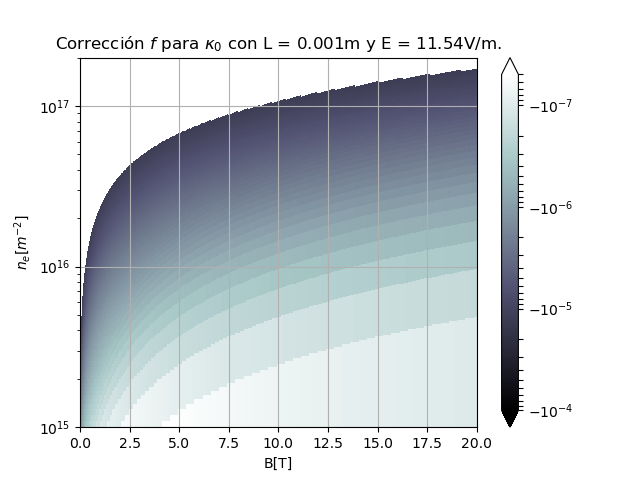

In [164]:
E = 11.54
L = 1E-3
dn_e = 1E14
nmin = 1E15
nmax = 2E17
n_e = np.arange(nmin,nmax,dn_e) #m^(-2)
B = np.arange(0.1,20,0.01)
B, n_e = np.meshgrid(B, n_e)

total = np.ceil(n_e*phi_0/B)
Necesario = 1+(n_c*phi_0/B)**(1/3)
Estado_Base = Necesario > total #Sector en el que sólo kappa_0 está lleno

fB = f(E, B, L, n_e)

fB2 = fB.copy()
fB2[Estado_Base==False] = fB.max()

Ordmin = np.ceil(np.log10(np.abs(np.min(fB2)))) #Orden de magnitud mínimo
Ordmax = np.floor(np.log10(np.abs(np.max(fB2)))) #Orden de magnitud máximo
#RECORDAR QUE LOS VALORES EN (-linthresh,linthresh) SON EN ESCALA LINEAL
norm = cm.colors.SymLogNorm(linthresh=1E-9, linscale=0.03,vmin=-10**Ordmin, vmax=-5*10**Ordmax, base=10) #colores en escala logarítmica
#norm = cm.colors.SymLogNorm(linthresh=1E-9, linscale=0.03,vmin=np.min(fB2), vmax=np.max(fB2), base=10)

fig = plt.figure()
ax = fig.add_subplot(111)
fB2[Estado_Base==False] = np.nan
cset = ax.pcolormesh(B, n_e, fB2,norm=norm, cmap='bone', shading='auto')
fig.colorbar(cset,extend='both')

plt.yscale('log')
plt.xlim(0,20)
plt.ylim(nmin,2E17)
plt.xlabel('B[T]')
plt.ylabel(r'$n_e[m^{-2}]$')
plt.title(r'Corrección $f$ para $\kappa_0$ con L = '+str(L)+'m y E = '+str(E)+'V/m.')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


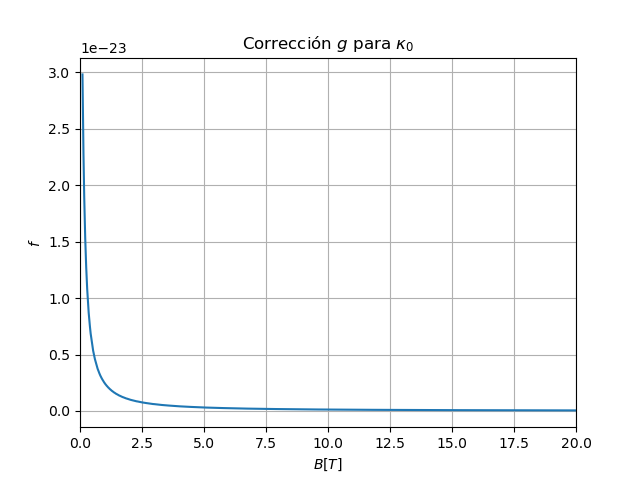

In [137]:
E = 11.54
L = 1E-3
n_e = 5E15
B = np.arange(0.1,20,0.01)
gB = []
for b in B:
    gB.append(g(E, b, L, n_e))
plt.plot(B,gB)

plt.xlabel(r'$B[T]$')
plt.ylabel(r'$f$')
plt.title(r'Corrección $g$ para $\kappa_0$')
#plt.ylim(-1,1)
plt.xlim(0,20)
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


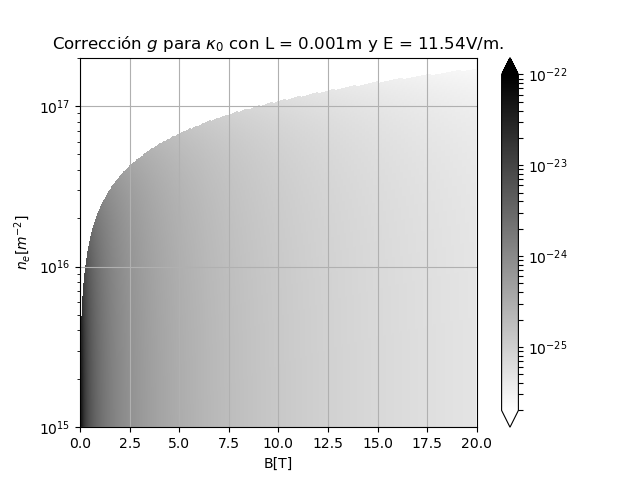

In [165]:
E = 11.54
L = 1E-3
dn_e = 1E14
nmin = 1E15
nmax = 2E17
n_e = np.arange(nmin,nmax,dn_e) #m^(-2)
B = np.arange(0.1,20,0.05)

gB = np.zeros((len(n_e),len(B)))
for i in range(len(B)):
    for j in range(len(n_e)):
        gB[j][i] = g(E, B[i], L, n_e[j])

B, n_e = np.meshgrid(B, n_e)

total = np.ceil(n_e*phi_0/B)
Necesario = 1+(n_c*phi_0/B)**(1/3)
Estado_Base = Necesario > total #Sector en el que sólo kappa_0 está lleno

gB2 = gB.copy()
gB2[Estado_Base==False] = gB.max()

Ordmin = np.floor(np.log10(np.abs(np.min(gB2)))) #Orden de magnitud mínimo
Ordmax = np.ceil(np.log10(np.abs(np.max(gB2)))) #Orden de magnitud máximo
#RECORDAR QUE LOS VALORES EN (-linthresh,linthresh) SON EN ESCALA LINEAL
norm = cm.colors.SymLogNorm(linthresh=1E-27, linscale=0.03,vmin=2*10**Ordmin, vmax=1*10**Ordmax, base=10) #colores en escala logarítmica
#norm = cm.colors.SymLogNorm(linthresh=1E-9, linscale=0.03,vmin=np.min(gB2), vmax=np.max(gB2), base=10)

fig = plt.figure()
ax = fig.add_subplot(111)
gB2[Estado_Base==False] = np.nan
cset = ax.pcolormesh(B, n_e, gB2,norm=norm, cmap='gist_yarg', shading='auto')
fig.colorbar(cset,extend='both')

plt.yscale('log')
plt.xlim(0,20)
plt.ylim(nmin,2E17)
plt.xlabel('B[T]')
plt.ylabel(r'$n_e[m^{-2}]$')
plt.title(r'Corrección $g$ para $\kappa_0$ con L = '+str(L)+'m y E = '+str(E)+'V/m.')
plt.grid()
plt.show()

In [15]:
A = ec**(3/2)/(m*np.sqrt(hbar)*c_light)*alpha**2/18

67651.2719951505

In [51]:
E = 11.54
B = 10
L = 1E-3 #Placa de un milímetro de grosor
E, B, L, B_tilde, E_tilde, l_B, l_E, l_Btilde, l_Etilde, Gamma, epsilon = Parámetros_Sistema(E, B, L, ctes)

In [39]:
Factor = l_E**3*l_Etilde**2/(l_B*l_Btilde**4)
Factor #El factor que me mandó, sí coinciden

1.0728232868783825e-19

In [40]:
Gamma #Sin embargo, para esos valores Gamma es grande

-831165.8576577965

In [41]:
1/9*Factor*Gamma**2 #Tomando que aproximadamente I_kk = -Gamma/3

8.234952009817559e-09

La corrección sigue siendo pequeña, pero según el Tong en la página 11 se tiene una precisión
sobre la medición en las mesetas de una parte en 10^9, que es exactamente el orden que nos sale!

In [18]:
2.25E-4*np.sqrt(10)*11.54*(1E-3)**2

8.210853944627196e-09

In [57]:
E = 11.54
B = 10
L = 1E-3 #Placa de un milímetro de grosor
E, B, L, B_tilde, E_tilde, l_B, l_E, l_Btilde, l_Etilde, Gamma, epsilon = Parámetros_Sistema(E, B, L, ctes)
epsilon

22.735848435177328

In [11]:
factor_f = alpha**2/18*ec**(3/2)/(m*hbar**(1/2)*c_light**2)
factor_f

0.0002256603533206646

In [23]:
Delta10 = (3*np.pi/4)**(2/3)*(1-3**(2/3))
factor_g = (alpha**2*ec**2*hbar**2/(4*m**4*c_light**10))**(1/3)
factor_g = factor_g*4/Delta10**5
factor_g

-1.532130736357249e-26

In [24]:
Delta10

-1.9124857983526393